In [5]:
import pickle
import pprint
from datetime import datetime
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pytz
import seaborn as sns
from matplotlib_venn import venn2
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
pl.Config.set_fmt_str_lengths(1000)


exp_number: '000'
run_time: base
data:
  input_root: ../../data/input
  train_path: ../../data/input/train_features.csv
  test_path: ../../data/input/test_features.csv
  sample_submission_path: ../../data/input/sample_submission.csv
  output_root: ../../data/output
  results_root: ../../results
  results_path: ../../results/000/base
seed: 319
n_splits: 5
target: target



polars.config.Config

### データの読み込み

In [6]:
# データの読み込み
train = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
sample_submission = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)


In [11]:
train


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be466631a_320""",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079
"""00066be8e20318869c38c66be466631a_420""",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083
"""00066be8e20318869c38c66be466631a_520""",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889
"""000fb056f97572d384bae4f5fc1e0f28_120""",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754
"""000fb056f97572d384bae4f5fc1e0f28_20""",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""fff88cca5f8a012427b96bdde66011e3_20""",-0.0,-0.0,16.102747,-1.0,0.0,true,0.0,false,"""drive""",false,true,0.00514,0.002648,-0.006207,0.013328,0.005834,-0.016368,0.019618,0.007763,-0.023074,0.028672,0.010737,-0.033795,0.0342,0.012502,-0.040583,0.043196,0.015644,-0.051309
"""fff88cca5f8a012427b96bdde66011e3_220""",1.594968,0.350129,-5.791823,-97.0,0.0,false,0.0,false,"""drive""",false,true,0.663311,-0.002493,-0.009528,1.516447,-0.004223,-0.020431,2.425366,-0.002958,-0.023108,3.319161,-0.012259,-0.027327,4.106655,-0.023314,-0.024449,4.708509,-0.027916,-0.026821
"""fff88cca5f8a012427b96bdde66011e3_320""",-0.004207,-0.037833,-2.089301,0.0,0.0,true,0.0,false,"""drive""",false,true,0.022788,0.000622,-0.006612,0.046445,0.001039,-0.017674,0.062182,0.000714,-0.024352,0.079601,0.000491,-0.034149,0.091362,-0.000041,-0.039632,0.10623,-0.001123,-0.04789


In [7]:
train.head()


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be466631a_320""",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079
"""00066be8e20318869c38c66be466631a_420""",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083
"""00066be8e20318869c38c66be466631a_520""",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889
"""000fb056f97572d384bae4f5fc1e0f28_120""",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754
"""000fb056f97572d384bae4f5fc1e0f28_20""",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243


In [9]:
train.shape


(43371, 30)

In [4]:
train.describe()


statistic,ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""43371""",43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,"""43371""",43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0,43371.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,9.172176,-0.015654,-2.065173,-19.009546,0.0,0.307602,0.084003,0.483595,null,0.077955,0.102718,4.122444,0.001949,0.001247,8.694386,0.004477,0.002618,13.255113,0.006758,0.003981,17.80058,0.009001,0.005223,22.330185,0.011159,0.006012,26.842607,0.013564,0.006648
"""std""",null,7.22692,0.632402,65.548822,110.799971,0.0,null,0.109837,null,null,null,null,3.266717,0.116866,0.040745,6.894355,0.327714,0.083388,10.52081,0.63765,0.127081,14.147079,1.041827,0.172892,17.772877,1.534514,0.220837,21.398114,2.111089,0.271671
"""min""","""00066be8e20318869c38c66be46663…",-0.161919,-4.936206,-481.394287,-700.0,0.0,0.0,0.0,0.0,"""drive""",0.0,0.0,-1.732154,-2.534138,-0.996548,-3.111055,-4.09071,-1.756772,-4.454273,-5.666513,-2.341347,-5.678676,-8.864628,-3.058673,-6.799718,-12.459174,-3.871224,-7.826888,-16.384152,-4.669255
"""25%""",null,2.578666,-0.236368,-3.461754,-94.0,0.0,null,0.0,null,null,null,null,1.116531,-0.026463,-0.017625,2.334773,-0.066491,-0.036768,3.548125,-0.119848,-0.057169,4.729803,-0.182733,-0.079274,5.916052,-0.256286,-0.101681,7.034703,-0.337794,-0.125354
"""50%""",null,8.51879,-1.8348e-15,-0.356471,-13.0,0.0,null,0.0,null,null,null,null,3.843337,0.001088,0.001111,8.0828,0.002699,0.002288,12.330558,0.003819,0.003061,16.567319,0.005099,0.004306,20.76318,0.00616,0.005289,24.947074,0.007994,0.005778
"""75%""",null,14.286816,0.222298,2.626907,51.0,0.0,null,0.165,null,null,null,null,6.42812,0.030664,0.019591,13.569839,0.077847,0.041457,20.699952,0.136715,0.06429,27.834049,0.206617,0.087344,34.947244,0.286427,0.111254,42.027569,0.372728,0.134984
"""max""","""fff88cca5f8a012427b96bdde66011…",27.551262,3.14007,484.691711,700.0,0.0,1.0,0.915,1.0,"""reverse""",1.0,1.0,12.392587,3.459556,1.447929,26.160461,3.220476,2.748179,39.855555,5.073225,3.920498,53.597005,8.201288,4.773078,67.242715,12.084923,5.743042,80.9889,17.151381,6.627251


In [8]:
train.select(pl.all().n_unique())


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
43371,42183,42207,43313,770,1,2,134,2,4,2,2,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371,43371


In [10]:
test.head()


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool
"""012baccc145d400c896cb82065a93d42_120""",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false
"""012baccc145d400c896cb82065a93d42_220""",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false
"""012baccc145d400c896cb82065a93d42_320""",3.604152,-0.286239,10.774388,-110.0,0.0,true,0.0,false,"""drive""",false,false
"""012baccc145d400c896cb82065a93d42_420""",2.048902,-0.537628,61.045235,189.0,0.0,true,0.0,false,"""drive""",true,false
"""01d738e799d260a10f6324f78023b38f_120""",2.201528,-1.8986,5.740093,-41.0,0.0,true,0.0,false,"""drive""",false,false


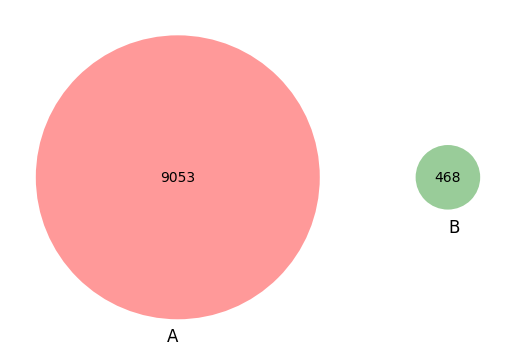

In [29]:
# 重複があるかベン図で確認

train_id_list = (
    train.select(pl.col("ID").str.split("_").list.get(0).unique(maintain_order=True).alias("ID_split"))
    .to_series()
    .to_list()
)
test_id_list = (
    test.select(pl.col("ID").str.split("_").list.get(0).unique(maintain_order=True).alias("ID_split"))
    .to_series()
    .to_list()
)

# 重複があるかベン図で確認

venn2([set(train_id_list), set(test_id_list)]);

# 同じsceneはなさそう


In [31]:
# scene列を作成 → これでGroupKFoldする
train = train.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))
test = test.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))
train.head()


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""00066be8e20318869c38c66be466631a_320""",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be466631a"""
"""00066be8e20318869c38c66be466631a_420""",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be466631a"""
"""00066be8e20318869c38c66be466631a_520""",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be466631a"""
"""000fb056f97572d384bae4f5fc1e0f28_120""",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f28"""
"""000fb056f97572d384bae4f5fc1e0f28_20""",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243,"""000fb056f97572d384bae4f5fc1e0f28"""
